In [1]:
import os
import re
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pysam
import sys

# ========== 0) Evaluation script ==========
SCRIPT = "/home/zqyin/mamba_test/Other_Model_test/imputation_accuracy_calculator/Compare_imputation_to_WGS.py"

# ========== 1) Truth (WGS) ==========
TRUTH_VCF = "/mnt/qmtang/EvoFill_data/20251211_chr22/data/minor_pops_all.vcf.gz"

# ========== 2) Test (masked) VCF ==========
TEST_VCF = "/mnt/qmtang/EvoFill_data/20251211_chr22/data/minor_pops_all.mask90p.vcf.gz"

# ========== 3) Imputed / phased outputs ==========
PRED = {
    "Eagle":"/home/zqyin/mamba_test/Other_Model_test/chr22/Eagle/minor_pops_all.mask90p.imputed.Eagle.vcf.gz",
    "EvoFill": "/home/zqyin/mamba_test/Other_Model_test/chr22/Evofill/ligated_results.noProb.vcf.gz",
    "Minimac": "/home/zqyin/mamba_test/Other_Model_test/chr22/Minimac/minor_pops_all.mask90p.imputed.minimac4.noGP.vcf.gz",
    "Beagle":  "/home/zqyin/mamba_test/Other_Model_test/chr22/Beagle/minor_pops_all.mask90p.imputed.Beagle.vcf.gz",
    "Shapeit": "/home/zqyin/mamba_test/Other_Model_test/chr22/Shapeit/minor_pops_all.mask90p.phased.shapeit5.vcf.gz",
    "STICI":"/home/zqyin/mamba_test/Other_Model_test/chr22/STICI/ligated_results.noProb.vcf.gz"
}

# ========== 4) Output directory (summary tables and plots) ==========
OUTDIR = "/home/zqyin/mamba_test/Other_Model_test/chr22/eval_summary_test"
os.makedirs(OUTDIR, exist_ok=True)

# ========== 5) MAF bins ==========
MAF_BINS   = [0.0, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
MAF_LABELS = ["0-0.05", "0.05-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.4", "0.4-0.5"]

# ========== 6) MAF bins for ACC/HC calculation (from EvoFill utils) ==========
try:
    SRC_DIR = "/mnt/qmtang/EvoFill/src"
    if SRC_DIR not in sys.path:
        sys.path.append(SRC_DIR)
    from utils import MAF_BINS as MAF_BINS_TUPLES
    # Convert from list of tuples to list of floats
    MAF_BINS_FOR_ACC = [0.0] + [hi for lo, hi in MAF_BINS_TUPLES]
except ImportError:
    # Fallback: use same bins as above
    MAF_BINS_FOR_ACC = MAF_BINS
    MAF_BINS_TUPLES = [(MAF_BINS[i], MAF_BINS[i+1]) for i in range(len(MAF_BINS)-1)]

def run(cmd, check=True):
    """Run a shell command (list format)."""
    print("[CMD]", " ".join(cmd))
    p = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    print(p.stdout)
    if check and p.returncode != 0:
        raise RuntimeError(f"Command failed (code={p.returncode}): {' '.join(cmd)}")
    return p.stdout

def ensure_index_vcfgz(vcfgz):
    """Ensure .tbi or .csi index exists for a bgzipped VCF (.vcf.gz)."""
    if os.path.exists(vcfgz + ".tbi") or os.path.exists(vcfgz + ".csi"):
        return
    # bcftools index -t generates a tabix index (.tbi), which is standard for vcf.gz
    run(["bcftools", "index", "-t", vcfgz])

def ensure_index_bcf(bcf):
    """Ensure .csi index exists for a BCF file."""
    if os.path.exists(bcf + ".csi") or os.path.exists(bcf + ".tbi"):
        return
    run(["bcftools", "index", bcf])

def shapeit_bcf_to_vcfgz(shapeit_bcf):
    """Convert Shapeit output from .bcf to .vcf.gz (bgzip) and index it."""
    out_vcfgz = re.sub(r"\.bcf$", ".vcf.gz", shapeit_bcf)
    if os.path.exists(out_vcfgz):
        ensure_index_vcfgz(out_vcfgz)
        return out_vcfgz
    run(["bcftools", "view", "-Oz", "-o", out_vcfgz, shapeit_bcf])
    ensure_index_vcfgz(out_vcfgz)
    return out_vcfgz

def run_compare(truth_vcf, imputed_vcf, max_total_rows=10000, max_per_core=1000, min_per_core=100):
    """Run Compare_imputation_to_WGS.py and parse output file paths."""
    ensure_index_vcfgz(truth_vcf)
    # Imputed input is assumed to be vcf.gz
    ensure_index_vcfgz(imputed_vcf)

    cmd = [
        "python3", SCRIPT,
        "--wgs", truth_vcf,
        "--imputed", imputed_vcf,
        "--max_total_rows", str(max_total_rows),
        "--max_per_core", str(max_per_core),
        "--min_per_core", str(min_per_core),
    ]
    out = run(cmd, check=True)

    # Extract output file paths from log
    per_sample = None
    per_variant = None
    for line in out.splitlines():
        if "Results per sample at:" in line:
            per_sample = line.split("Results per sample at:")[-1].strip()
        if "Results per variant at:" in line:
            per_variant = line.split("Results per variant at:")[-1].strip()

    if not per_variant or not os.path.exists(per_variant):
        raise FileNotFoundError("Cannot find per-variant result file from script output.")
    return per_variant, per_sample

def gt_to_code_biallelic(gt_tuple):
    """Convert GT to 0/1/2 (ALT dosage). Only accepts biallelic 0/1 encoding."""
    if gt_tuple is None:
        return -1
    if any(a is None for a in gt_tuple):
        return -1
    try:
        a0, a1 = int(gt_tuple[0]), int(gt_tuple[1])
    except Exception:
        return -1
    if a0 < 0 or a1 < 0:
        return -1
    if a0 not in (0, 1) or a1 not in (0, 1):
        return -1
    return a0 + a1  # 0, 1, or 2

def is_missing_gt(gt_tuple):
    if gt_tuple is None:
        return True
    if any(a is None for a in gt_tuple):
        return True
    try:
        a0, a1 = int(gt_tuple[0]), int(gt_tuple[1])
    except Exception:
        return True
    return (a0 < 0 or a1 < 0)

def maf_bin_index(maf, bins):
    """bins: list of (lo, hi) tuples"""
    for i, (lo, hi) in enumerate(bins):
        if maf >= lo and maf < hi:
            return i
    return len(bins) - 1

def compute_acc_hc_metrics(truth_vcf_path, test_vcf_path, pred_vcf_path, tool_name, progress_every=200000):
    """
    Compute ACC (accuracy) and HC (heterozygosity concordance) metrics per MAF bin.
    Returns a DataFrame with columns: maf_bin, Acc_mean, Acc_var, HC_mean, HC_var
    """
    print(f"[INFO] Computing ACC and HC for {tool_name}...")
    
    B = len(MAF_BINS_TUPLES)
    bin_labels = [f"{lo}-{hi}" for (lo, hi) in MAF_BINS_TUPLES] + ["ALL"]
    ALL_BIN = B
    
    # ACC stats
    acc_sum = np.zeros(B + 1, dtype=np.float64)
    acc_sumsq = np.zeros(B + 1, dtype=np.float64)
    acc_nsite = np.zeros(B + 1, dtype=np.int64)
    
    # HC stats
    hc_nsite = np.zeros(B + 1, dtype=np.int64)
    hc_sum = np.zeros(B + 1, dtype=np.float64)
    hc_sumsq = np.zeros(B + 1, dtype=np.float64)
    hc_den_total = np.zeros(B + 1, dtype=np.int64)
    hc_num_total = np.zeros(B + 1, dtype=np.int64)
    
    truth_sites_per_bin = np.zeros(B + 1, dtype=np.int64)
    
    truth_vcf = pysam.VariantFile(truth_vcf_path)
    test_vcf = pysam.VariantFile(test_vcf_path)
    pred_vcf = pysam.VariantFile(pred_vcf_path)
    
    samples = list(truth_vcf.header.samples)
    N = len(samples)
    
    assert list(test_vcf.header.samples) == samples, "[ERROR] TEST_VCF samples != TRUTH"
    assert list(pred_vcf.header.samples) == samples, f"[ERROR] {tool_name} samples != TRUTH"
    
    truth_it = truth_vcf.fetch()
    test_it = test_vcf.fetch()
    pred_it = pred_vcf.fetch()
    
    L = 0
    while True:
        try:
            rec_truth = next(truth_it)
        except StopIteration:
            break
        
        try:
            rec_test = next(test_it)
        except StopIteration:
            raise RuntimeError("[ERROR] truth/test mismatch: test ended early")
        
        try:
            rec_pred = next(pred_it)
        except StopIteration:
            raise RuntimeError(f"[ERROR] truth/{tool_name} mismatch: {tool_name} ended early")
        
        # Site consistency check
        contig = rec_truth.contig
        pos = rec_truth.pos
        ref = rec_truth.ref
        alts = rec_truth.alts
        
        def same_site(r):
            return (r.contig == contig and r.pos == pos and r.ref == ref and r.alts == alts)
        
        if not same_site(rec_test) or not same_site(rec_pred):
            continue  # Skip mismatched sites
        
        # Get genotypes
        truth_code = np.empty(N, dtype=np.int8)
        test_miss = np.empty(N, dtype=bool)
        pred_code = np.empty(N, dtype=np.int8)
        
        for i, s in enumerate(samples):
            truth_code[i] = gt_to_code_biallelic(rec_truth.samples[s].get("GT"))
            test_miss[i] = is_missing_gt(rec_test.samples[s].get("GT"))
            pred_code[i] = gt_to_code_biallelic(rec_pred.samples[s].get("GT"))
        
        # Compute MAF
        valid = (truth_code >= 0)
        n_valid = int(valid.sum())
        if n_valid <= 0:
            L += 1
            continue
        
        alt_total = float(np.where(valid, truth_code, 0).sum())
        freq = alt_total / (2.0 * n_valid)
        maf = min(freq, 1.0 - freq)
        bidx = maf_bin_index(maf, MAF_BINS_TUPLES)
        
        truth_sites_per_bin[bidx] += 1
        truth_sites_per_bin[ALL_BIN] += 1
        
        # Compute ACC
        eval_acc_mask = test_miss & (truth_code >= 0) & (pred_code >= 0)
        n_eval = int(eval_acc_mask.sum())
        if n_eval > 0:
            correct = int(((truth_code == pred_code) & eval_acc_mask).sum())
            acc_site = correct / float(n_eval)
            
            acc_sum[bidx] += acc_site
            acc_sumsq[bidx] += acc_site * acc_site
            acc_nsite[bidx] += 1
            
            acc_sum[ALL_BIN] += acc_site
            acc_sumsq[ALL_BIN] += acc_site * acc_site
            acc_nsite[ALL_BIN] += 1
        
        # Compute HC
        het_truth = (truth_code == 1)
        eval_hc_mask = het_truth & test_miss
        den_site = int(eval_hc_mask.sum())
        
        if den_site > 0:
            pred_het = (pred_code == 1)
            num_site = int((eval_hc_mask & pred_het).sum())
            hc_site = num_site / float(den_site)
            
            hc_nsite[bidx] += 1
            hc_sum[bidx] += hc_site
            hc_sumsq[bidx] += hc_site * hc_site
            hc_den_total[bidx] += den_site
            hc_num_total[bidx] += num_site
            
            hc_nsite[ALL_BIN] += 1
            hc_sum[ALL_BIN] += hc_site
            hc_sumsq[ALL_BIN] += hc_site * hc_site
            hc_den_total[ALL_BIN] += den_site
            hc_num_total[ALL_BIN] += num_site
        
        L += 1
        if progress_every and (L % progress_every == 0):
            print(f"[INFO] {tool_name} processed sites: {L}")
    
    truth_vcf.close()
    test_vcf.close()
    pred_vcf.close()
    
    # Build result DataFrame
    results = []
    for i, blab in enumerate(bin_labels):
        # ACC
        n_acc = int(acc_nsite[i])
        if n_acc > 0:
            s = float(acc_sum[i])
            ss = float(acc_sumsq[i])
            acc_mean = s / n_acc
            if n_acc >= 2:
                acc_var = (ss - (s * s) / n_acc) / (n_acc - 1)
                if acc_var < 0 and acc_var > -1e-12:
                    acc_var = 0.0
            else:
                acc_var = np.nan
        else:
            acc_mean = np.nan
            acc_var = np.nan
        
        # HC
        n_hc = int(hc_nsite[i])
        if n_hc > 0:
            s = float(hc_sum[i])
            ss = float(hc_sumsq[i])
            hc_mean = s / n_hc
            if n_hc >= 2:
                hc_var = (ss - (s * s) / n_hc) / (n_hc - 1)
            else:
                hc_var = np.nan
            den_sum = int(hc_den_total[i])
            num_sum = int(hc_num_total[i])
        else:
            hc_mean = np.nan
            hc_var = np.nan

        
        results.append({
            "maf_bin": blab,
            "Acc_mean": acc_mean,
            "Acc_var": acc_var,
            "HC_mean": hc_mean,
            "HC_var": hc_var,

        })
    
    df = pd.DataFrame(results)
    df["maf_bin"] = pd.Categorical(df["maf_bin"], categories=bin_labels, ordered=True)
    df = df.sort_values("maf_bin").reset_index(drop=True)
    
    # Round values
    for c in ["Acc_mean", "Acc_var", "HC_mean", "HC_var"]:
        df[c] = df[c].astype(float).round(6)
    
    return df

def maf_bin_summary(per_variant_tsv, tool_name):
    """
    Read per-variant results, bin variants by WGS_MAF, and compute
    mean/variance for F-score, IQS, r2, and RMSE.
    """
    df = pd.read_csv(per_variant_tsv, sep="\t", dtype=str)

    # ====== Required columns ======
    base_need = ["WGS_MAF", "F-score", "IQS", "r2", "RMSE"]
    miss = [c for c in base_need if c not in df.columns]
    if miss:
        raise ValueError(f"[{tool_name}] Missing columns in {per_variant_tsv}: {miss}")

    # ====== Convert required columns to numeric ======
    need_numeric = base_need
    for c in need_numeric:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=need_numeric).copy()
    df["WGS_MAF"] = df["WGS_MAF"].clip(0.0, 0.5)

    # ====== MAF binning ======
    df["maf_bin"] = pd.cut(
        df["WGS_MAF"], bins=MAF_BINS, labels=MAF_LABELS,
        right=False, include_lowest=True
    )
    df.loc[df["WGS_MAF"] == 0.5, "maf_bin"] = "0.4-0.5"
    df = df.dropna(subset=["maf_bin"]).copy()

    # ====== Aggregation ======
    agg = df.groupby("maf_bin", observed=False).agg(
        n_variants=("WGS_MAF", "size"),
        WGS_MAF_mean=("WGS_MAF", "mean"),

        Fscore_mean=("F-score", "mean"),
        Fscore_sd=("F-score", "var"),

        IQS_mean=("IQS", "mean"),
        IQS_sd=("IQS", "var"),

        r2_mean=("r2", "mean"),
        r2_sd=("r2", "var"),

        RMSE_mean=("RMSE", "mean"),
        RMSE_sd=("RMSE", "var"),
    ).reset_index()

    # Preserve bin order
    agg["maf_bin"] = pd.Categorical(agg["maf_bin"], categories=MAF_LABELS, ordered=True)
    agg = agg.sort_values("maf_bin").reset_index(drop=True)

    # Round values
    for c in [
        "WGS_MAF_mean",
        "Fscore_mean", "Fscore_sd",
        "IQS_mean", "IQS_sd",
        "r2_mean", "r2_sd",
        "RMSE_mean", "RMSE_sd",
    ]:
        agg[c] = agg[c].astype(float).round(4)

    agg.insert(0, "tool", tool_name)
    return agg


In [2]:
tools_to_run = {
    "Shapeit": PRED["Shapeit"],
    "Eagle": PRED["Eagle"],
    "Minimac": PRED["Minimac"],
    "STICI": PRED["STICI"],
    "Beagle": PRED["Beagle"],
    "EvoFill": PRED["EvoFill"],
}

# Store all results
per_variant_paths = {}
acc_hc_results = {}

for tool, imputed in tools_to_run.items():
    print(f"\n{'='*80}")
    print(f"========== Evaluating {tool} ==========")
    print(f"{'='*80}")
    
    # 1) Run Compare script for F-score, IQS, r2, RMSE
    print(f"\n[Step 1/2] Running Compare script for {tool}...")
    per_variant, per_sample = run_compare(TRUTH_VCF, imputed)
    per_variant_paths[tool] = per_variant
    print(f"[OK] {tool} per-variant: {per_variant}")
    print(f"[OK] {tool} per-sample : {per_sample}")
    
    # 2) Compute ACC and HC metrics
    print(f"\n[Step 2/2] Computing ACC and HC for {tool}...")
    acc_hc_df = compute_acc_hc_metrics(TRUTH_VCF, TEST_VCF, imputed, tool, progress_every=200000)
    acc_hc_results[tool] = acc_hc_df
    print(f"[OK] {tool} ACC/HC computation completed")
    
    print(f"\n[OK] {tool} evaluation completed!")


========== Evaluating Shapeit ==========

[Step 1/2] Running Compare script for Shapeit...
[CMD] python3 /home/zqyin/mamba_test/Other_Model_test/imputation_accuracy_calculator/Compare_imputation_to_WGS.py --wgs /mnt/qmtang/EvoFill_data/20251211_chr22/data/minor_pops_all.vcf.gz --imputed /home/zqyin/mamba_test/Other_Model_test/chr22/Shapeit/minor_pops_all.mask90p.phased.shapeit5.vcf.gz --max_total_rows 10000 --max_per_core 1000 --min_per_core 100


Namespace(ga='', wgs=['/mnt/qmtang/EvoFill_data/20251211_chr22/data/minor_pops_all.vcf.gz'], imputed=['/home/zqyin/mamba_test/Other_Model_test/chr22/Shapeit/minor_pops_all.mask90p.phased.shapeit5.vcf.gz'], ref='', max_total_rows=[10000], max_per_core=[1000], min_per_core=[100], sout='', vout='', xmode='False', disable_warnings='False')
10000 1000 100
Processing  93 imputed samples
Processing chunk: 1 Max rows per chunk: 10000
Processing chunk: 2 Max rows per chunk: 10000
Processing chunk: 3 Max rows per chunk: 10000
Processing chunk: 4 Max rows per chunk: 10000
Processing chunk: 5 Max rows per chunk: 10000
Processing chunk: 6 Max rows per chunk: 10000
Processing chunk: 7 Max rows per chunk: 10000
Processing chunk: 8 Max rows per chunk: 10000
Processing chunk: 9 Max rows per chunk: 10000
Processing chunk: 10 Max rows per chunk: 10000
Processing chunk: 11 Max rows per chunk: 10000
Processing chunk: 12 Max rows per chunk: 10000
Processing chunk: 13 Max rows per chunk: 10000
Processing chu


Merging all evaluation metrics...
[OK] Saved: /home/zqyin/mamba_test/Other_Model_test/chr22/eval_summary_test/mafbin_summary_all_metrics.tsv
[OK] Saved: /home/zqyin/mamba_test/Other_Model_test/chr22/eval_summary_test/mafbin_summary_all_metrics.xlsx

Summary Statistics:
       tool   maf_bin n_variants WGS_MAF_mean Fscore_mean Fscore_sd IQS_mean  \
0   Shapeit    0-0.05     109870       0.0057      0.9952    0.0003    0.179   
1   Shapeit  0.05-0.1      15765       0.0734      0.9738     0.001   0.7606   
2   Shapeit   0.1-0.2      22521       0.1481      0.9649    0.0014   0.7899   
3   Shapeit   0.2-0.3      14896       0.2476      0.9552    0.0018   0.7842   
4   Shapeit   0.3-0.4      13774       0.3501      0.9552    0.0019   0.7951   
5   Shapeit   0.4-0.5      13358       0.4502      0.9535    0.0019   0.7901   
6   Shapeit       ALL     109870       0.0057      0.9952    0.0003    0.179   
7     Eagle    0-0.05     109870       0.0057      0.9971    0.0001   0.1896   
8     Eag

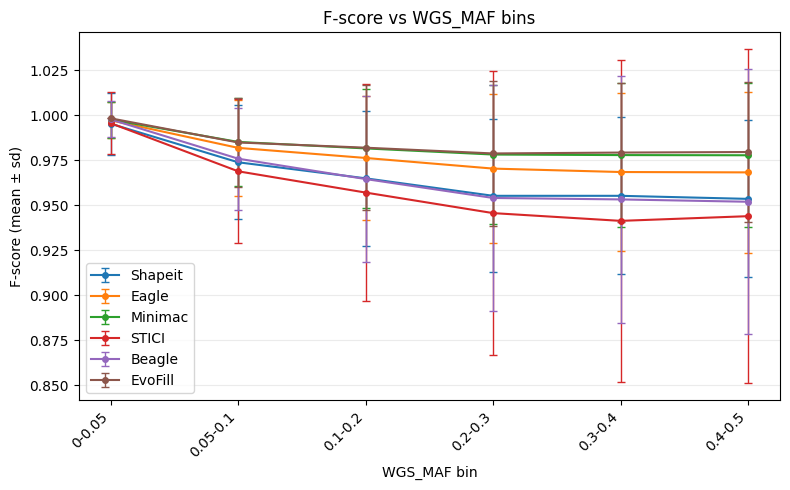

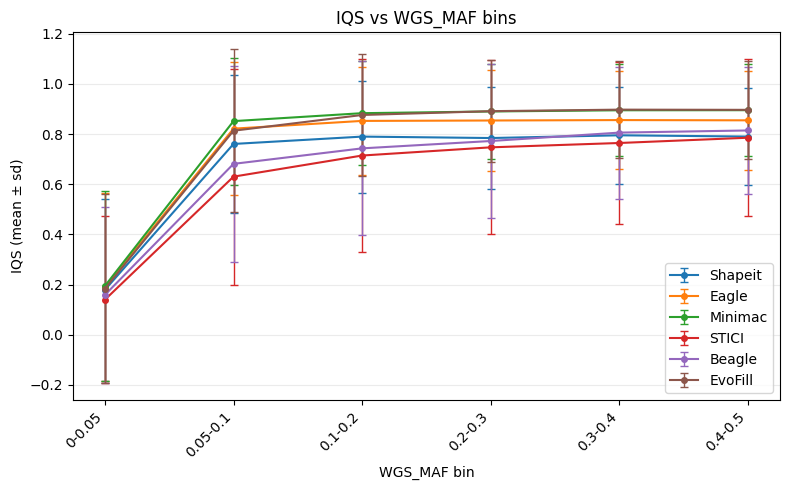

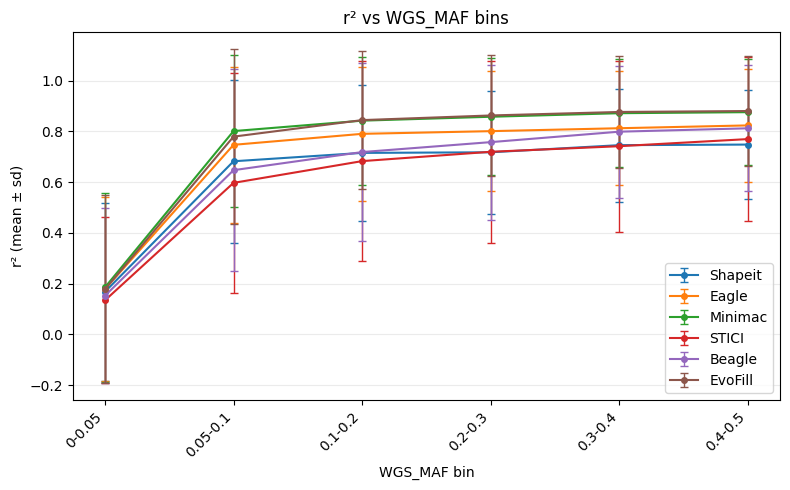

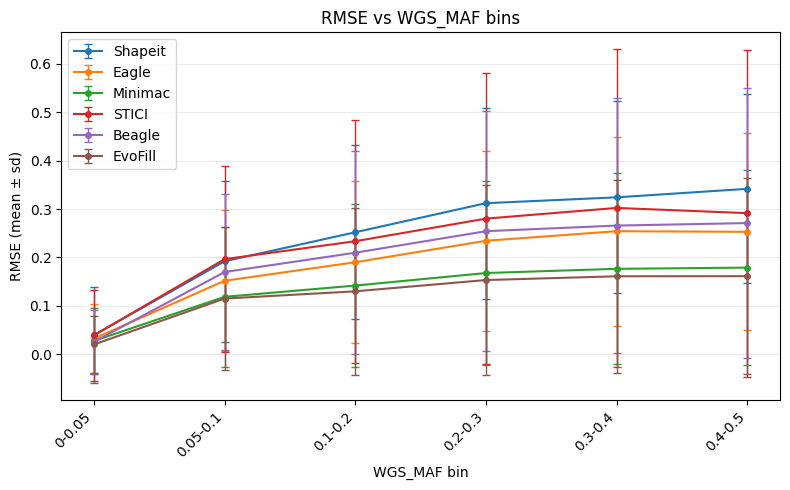

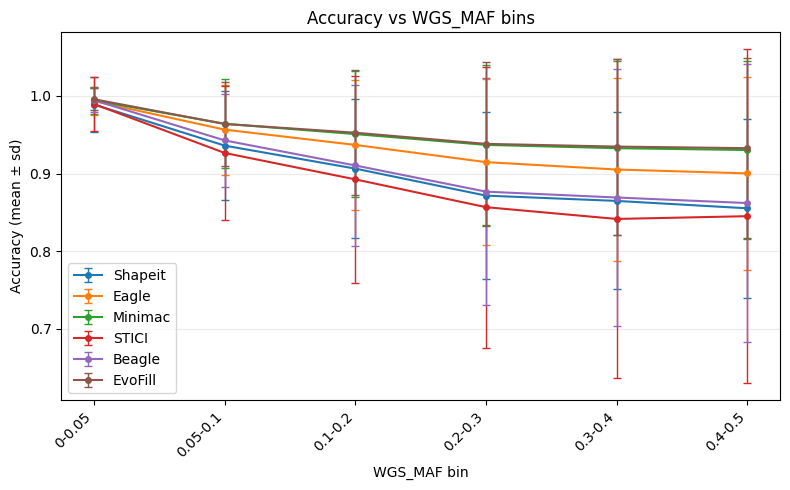

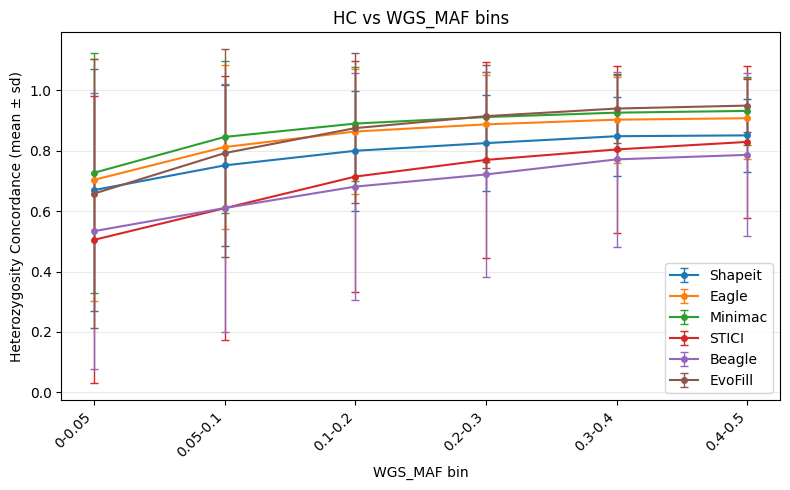


[OK] All plots generated!


In [3]:
# ========== 1) Process Compare results (F-score, IQS, r2, RMSE) ==========
print("\n" + "="*80)
print("Merging all evaluation metrics...")
print("="*80)

summaries = []
for tool, pv in per_variant_paths.items():
    s = maf_bin_summary(pv, tool)
    summaries.append(s)

summary_compare = pd.concat(summaries, ignore_index=True)

# ========== 2) Process ACC and HC results ==========
# Map ACC/HC bin labels to Compare bin labels
# ACC/HC uses MAF_BINS_TUPLES, Compare uses MAF_BINS
bin_label_map = {}
for i, (lo, hi) in enumerate(MAF_BINS_TUPLES):
    # Find matching bin in MAF_LABELS
    for j, label in enumerate(MAF_LABELS):
        label_lo, label_hi = map(float, label.split("-"))
        if abs(label_lo - lo) < 0.001 and abs(label_hi - hi) < 0.001:
            bin_label_map[f"{lo}-{hi}"] = label
            break
    else:
        # If no exact match, use closest
        bin_label_map[f"{lo}-{hi}"] = MAF_LABELS[min(i, len(MAF_LABELS)-1)]

# Merge ACC/HC results with Compare results
summary_merged_list = []
for tool in summary_compare["tool"].unique():
    compare_df = summary_compare[summary_compare["tool"] == tool].copy()
    acc_hc_df = acc_hc_results[tool].copy()
    
    # Map ACC/HC bin labels to Compare bin labels (excluding "ALL")
    acc_hc_df_filtered = acc_hc_df[acc_hc_df["maf_bin"] != "ALL"].copy()
    acc_hc_df_filtered["maf_bin_mapped"] = acc_hc_df_filtered["maf_bin"].map(
        lambda x: bin_label_map.get(x, x)
    )
    
    # Merge on maf_bin
    merged = compare_df.merge(
        acc_hc_df_filtered[["maf_bin_mapped", "Acc_mean", "Acc_var", "HC_mean", "HC_var"]],
        left_on="maf_bin",
        right_on="maf_bin_mapped",
        how="left"
    )
    merged = merged.drop(columns=["maf_bin_mapped"])
    
    # Add ALL bin results if available
    all_row = acc_hc_df[acc_hc_df["maf_bin"] == "ALL"]
    if len(all_row) > 0:
        # Find a representative row to add ALL metrics
        all_metrics = all_row.iloc[0]
        # Add as a new row with maf_bin="ALL"
        all_row_merged = compare_df.iloc[0].copy()
        all_row_merged["maf_bin"] = "ALL"
        all_row_merged["Acc_mean"] = all_metrics["Acc_mean"]
        all_row_merged["Acc_var"] = all_metrics["Acc_var"]
        all_row_merged["HC_mean"] = all_metrics["HC_mean"]
        all_row_merged["HC_var"] = all_metrics["HC_var"]
        merged = pd.concat([merged, all_row_merged.to_frame().T], ignore_index=True)
    
    summary_merged_list.append(merged)

summary_all = pd.concat(summary_merged_list, ignore_index=True)

# ========== 3) Save results ==========
out_tsv = os.path.join(OUTDIR, "mafbin_summary_all_metrics.tsv")
summary_all.to_csv(out_tsv, sep="\t", index=False)
print(f"[OK] Saved: {out_tsv}")

out_xlsx = os.path.join(OUTDIR, "mafbin_summary_all_metrics.xlsx")
with pd.ExcelWriter(out_xlsx) as w:
    for tool in summary_all["tool"].unique():
        summary_all[summary_all["tool"] == tool].drop(columns=["tool"]).to_excel(w, sheet_name=tool, index=False)
print(f"[OK] Saved: {out_xlsx}")

# Display summary
print("\n" + "="*80)
print("Summary Statistics:")
print("="*80)
print(summary_all.head(20))

# ========== 4) Plotting functions ==========
def plot_compare_with_errorbar(summary_all, mean_col, sd_col, y_label, title, out_svg, exclude_all=True):
    """Plot with error bars. If exclude_all=True, exclude rows where maf_bin=='ALL'."""
    os.makedirs(os.path.dirname(out_svg), exist_ok=True)

    fig, ax = plt.subplots(figsize=(8, 5))

    plot_df = summary_all[summary_all["maf_bin"] != "ALL"] if exclude_all else summary_all
    if exclude_all:
        x_labels = MAF_LABELS
    else:
        x_labels = list(plot_df["maf_bin"].unique())
        x_labels = [l for l in x_labels if l != "ALL"] + (["ALL"] if "ALL" in x_labels else [])
    
    x = np.arange(len(x_labels), dtype=float)

    for tool in plot_df["tool"].unique():
        d = plot_df[plot_df["tool"] == tool].copy()
        if exclude_all:
            d = d[d["maf_bin"] != "ALL"]
        
        # Align with x_labels order
        y = []
        yerr = []
        for label in x_labels:
            row = d[d["maf_bin"] == label]
            if len(row) > 0:
                y_val = row[mean_col].iloc[0]
                if sd_col is not None and sd_col in row.columns:
                    yerr_val = row[sd_col].iloc[0] if not pd.isna(row[sd_col].iloc[0]) else 0
                    yerr.append(np.sqrt(yerr_val) if not pd.isna(yerr_val) and yerr_val >= 0 else 0)
                else:
                    yerr.append(0)
                y.append(y_val if not pd.isna(y_val) else 0)
            else:
                y.append(np.nan)
                yerr.append(0)
        
        y = np.array(y)
        yerr = np.array(yerr)
        
        # Only plot if we have valid data
        valid = ~np.isnan(y)
        if valid.sum() > 0:
            ax.errorbar(
                x[valid], y[valid], yerr=yerr[valid],
                fmt="-o", linewidth=1.5, markersize=4,
                capsize=3, elinewidth=1.0,
                label=tool
            )

    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha="right")
    ax.set_xlabel("WGS_MAF bin")
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(True, axis="y", alpha=0.25)
    ax.legend()
    fig.tight_layout()

    fig.savefig(out_svg, format="svg", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

# ========== 5) Generate all plots ==========
print("\n" + "="*80)
print("Generating plots...")
print("="*80)

# F-score, IQS, r2, RMSE plots
plot_compare_with_errorbar(
    summary_all,
    mean_col="Fscore_mean", sd_col="Fscore_sd",
    y_label="F-score (mean ± sd)",
    title="F-score vs WGS_MAF bins",
    out_svg=os.path.join(OUTDIR, "Fscore_mean.svg")
)

plot_compare_with_errorbar(
    summary_all,
    mean_col="IQS_mean", sd_col="IQS_sd",
    y_label="IQS (mean ± sd)",
    title="IQS vs WGS_MAF bins",
    out_svg=os.path.join(OUTDIR, "IQS_mean.svg")
)

plot_compare_with_errorbar(
    summary_all,
    mean_col="r2_mean", sd_col="r2_sd",
    y_label="r² (mean ± sd)",
    title="r² vs WGS_MAF bins",
    out_svg=os.path.join(OUTDIR, "r2_mean.svg")
)

plot_compare_with_errorbar(
    summary_all,
    mean_col="RMSE_mean", sd_col="RMSE_sd",
    y_label="RMSE (mean ± sd)",
    title="RMSE vs WGS_MAF bins",
    out_svg=os.path.join(OUTDIR, "RMSE_mean.svg")
)

# ACC plot
plot_compare_with_errorbar(
    summary_all,
    mean_col="Acc_mean", sd_col="Acc_var",
    y_label="Accuracy (mean ± sd)",
    title="Accuracy vs WGS_MAF bins",
    out_svg=os.path.join(OUTDIR, "Acc_mean.svg")
)

# HC plots
plot_compare_with_errorbar(
    summary_all,
    mean_col="HC_mean", sd_col="HC_var",
    y_label="Heterozygosity Concordance (mean ± sd)",
    title="HC vs WGS_MAF bins",
    out_svg=os.path.join(OUTDIR, "HC_mean.svg")
)


print("\n[OK] All plots generated!")

